In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import Callback

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


In [10]:
# Specify dataset path
dataset_path = "E:/SML Project/plantvillagedataset/color"  # Update with the correct path

# Define ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    validation_split=0.2,      # Split dataset: 80% train, 20% validation
    rotation_range=30,         # Random rotations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True       # Random horizontal flips
)

# Prepare training data generator (resize images to (224, 224))
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to (224, 224) to match MobileNet's input size
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training',         # Use the 'training' subset for training data
    shuffle=True               # Shuffle the data
)

# Prepare validation data generator (resize images to (224, 224))
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to (224, 224) to match MobileNet's input size
    batch_size=32,
    class_mode='categorical', # Multi-class classification
    subset='validation',      # Use the 'validation' subset for validation data
    shuffle=False             # Don't shuffle validation data
)


Found 18110 images belonging to 38 classes.
Found 4510 images belonging to 38 classes.


In [11]:
# Load the MobileNet model pre-trained on ImageNet without the top layers
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to retain learned features
for layer in mobilenet_base.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    mobilenet_base,  # Add the pre-trained MobileNet base
    GlobalAveragePooling2D(),  # Replace Flatten with GlobalAveragePooling for better performance
    Dense(128, activation='relu'),  # Add a dense layer for learning task-specific features
    Dropout(0.5),  # Regularization to reduce overfitting
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,364,966 (12.84 MB)

 Trainable params: 136,102 (531.65 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [12]:
# Define a custom callback to display remaining time during training
class TimeRemainingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()  # Record the training start time

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.epoch_start_time = time.time()  # Record the first epoch start time

    def on_epoch_end(self, epoch, logs=None):
        current_time = time.time()
        time_per_epoch = current_time - self.epoch_start_time
        remaining_epochs = self.params['epochs'] - (epoch + 1)
        estimated_time_remaining = time_per_epoch * remaining_epochs
        
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']} completed.")
        print(f"Time per epoch: {time_per_epoch:.2f} seconds.")
        print(f"Estimated time remaining: {estimated_time_remaining:.2f} seconds.\n")

        # Update epoch start time for the next epoch
        self.epoch_start_time = current_time

# Instantiate the custom callback
time_remaining_callback = TimeRemainingCallback()

# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=5,  # Adjust epochs as needed
    validation_data=validation_generator,  # Use validation data for evaluation
    callbacks=[time_remaining_callback]  # Add the custom callback
)


Epoch 1/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5310 - loss: 1.8227
Epoch 1/5 completed.
Time per epoch: 887.05 seconds.
Estimated time remaining: 3548.19 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.5313 - loss: 1.8216 - val_accuracy: 0.8984 - val_loss: 0.3646
Epoch 2/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8165 - loss: 0.6035
Epoch 2/5 completed.
Time per epoch: 523.97 seconds.
Estimated time remaining: 1571.91 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 524s 926ms/step - accuracy: 0.8165 - loss: 0.6034 - val_accuracy: 0.9153 - val_loss: 0.2679
Epoch 3/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8537 - loss: 0.4592
Epoch 3/5 completed.
Time per epoch: 789.90 seconds.
Estimated time remaining: 1579.81 seconds.

566/566 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.8537 - loss: 0.4591 - val_accuracy: 0.9328 - val_loss: 0.2148
Epoch 4/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8700 - loss: 0.3989
Epoch 4/5 com

141/141 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9494 - loss: 0.1527
Validation Accuracy: 93.64%


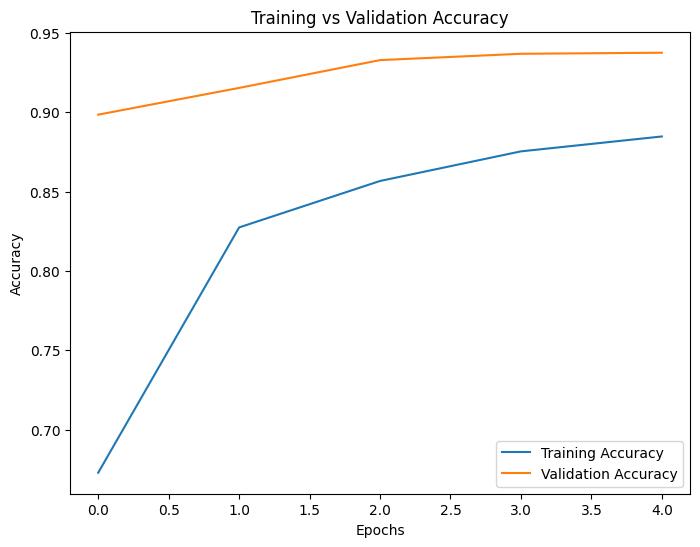

In [13]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training vs. validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# ....

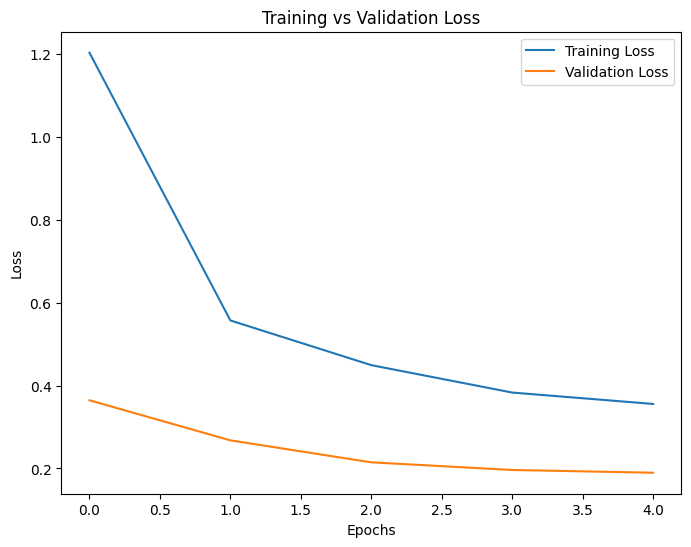

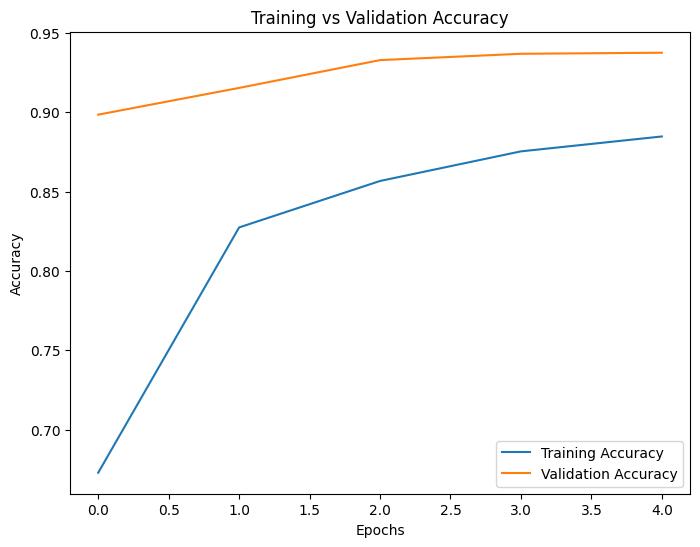

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
# Assuming the model is already loaded and trained, and it's named 'model'
# If not, you can load the model using model = tf.keras.models.load_model('model_path')

# Load and preprocess an image for prediction
img_path = r"C:\Users\HP\Downloads\img.JPG"  # Correct the path format

# Resize the image to match model input size (224x224 as expected by your model)
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
img_array = image.img_to_array(img) / 255.0  # Convert image to array and normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension for prediction

# Predict the disease class
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the class with the highest probability

# Map the predicted index to class labels
class_names = list(train_generator.class_indices.keys())  # Get the class labels from the training data generator
predicted_class = class_names[predicted_class_index]  # Get the predicted class name
print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted class is: Potato___Early_blight


In [18]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained model and validation generator
validation_labels = []
validation_predicted_classes = []

# Iterate over the validation data generator and collect true labels and predictions
for batch in validation_generator:
    # Get the true labels from the generator
    true_labels = batch[1]
    validation_labels.extend(np.argmax(true_labels, axis=1))  # Convert one-hot encoding to labels

    # Get the predictions from the model
    predictions = model.predict(batch[0])
    predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted class labels
    validation_predicted_classes.extend(predicted_classes)

# Now you can generate the classification report
report = classification_report(validation_labels, validation_predicted_classes, 
                               target_names=validation_generator.class_indices.keys(), zero_division=0)

# Print the classification report
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

KeyboardInterrupt: 

In [19]:
# Save the trained model for future use
model.save("Model-mobilnet.h5")
print("Model-mobilnet.h5")


Model-mobilnet.h5
